## ПРОГНОЗИРОВАНИЕ ВРЕМЕННЫХ РЯДОВ С ИЕРАРХИЧЕСКОЙ СТРУКТУРОЙ

### Оглавление

- Введение
- Обзор литературы
- Теоретичсекая часть: описание моделей
    - AR(3)
    - AR(3) + structural break 
    - NOPE AR(3)LI with neighbors (different metrics)
    - Взвешенные прогнозы
    - HB (Иерархический Байес с выделением разных групп  по разным метрикам кластеризации)
- Практическая часть 
    - Данные 
    - CV
        - [How To Backtest Machine Learning Models for Time Series Forecasting](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)
        - [Evaluating forecast accuracy](https://otexts.com/fpp2/accuracy.html)
        - Чтобы были сопоставимы, делаем кроссвалидацию с увеличивающимся окном 
    - DM test
        - We cannot compare forecasts for VECTORS of differing (in this case increasing) points in time, we must use a rolling window approach with a fixed h to compare these two models' h-point forecasts along time
        - Also, note that Diebold himself suggests not using Diebold-Mariano test for comparing models rather than forecasts (Diebold "Comparing predictive accuracy, twenty years later: A personal perspective on the use and abuse of Diebold–Mariano tests", 2015).
        - [use and abuse](https://www.sas.upenn.edu/~fdiebold/papers/paper113/Diebold_DM%20Test.pdf)

    - Сравнение моделей
        
  

### Практическая часть


#### Данные

Для анализа были выбраны три набора данных с иерархической структурой с разной сезонностью:  квартальные, квартальные сезонно сглаженные и месячные данные. Для каждого из наборов выполняется следующее: 
структура трехуровневая и иерархическая, причем на втором уровне $i=1,\dots,I$ рядов, каждый из которых разбивается на $J$ рядов третьего уровня, так, что просуммировав имеем

$$y_t = \sum_{i=1}^I y_{i,t} = \sum_{i=1}^I \sum_{j=1}^J y_{ij,t} $$

где $y_{ij,t}, y_{i,t},  y_{t}  $ - значение ряда ряда соответсвующего уровня в момент времени $t$. 

Отметим, что поиск реальных данных, идеально подходящих под такую структуру, сильно затруднен, поскольку при сборе данных по большому числу показателей нередки ошибки и неточности, двойной учет, изменения в методолгях сбора и прочие проблемы, с которыми сложно бороться. При анализе ВВП в разбивке на основные отрасли, мы имеем дело  с иным показателем - валовой добаленной стоимостью (ВДС), которая при суммировании в общем случае получается меньше ВВП на величину чистых субсидий на налогов на производство и импорт, которые в приницпе могут быть  расчитаны только на уровне страны. По этой причине, для ЕС и США прогнозировать мы будем не сами ряды ВВП, а аггрегированные показатели по ВВП, являющиеся простой суммой из рядов нижнего уровня. 

Этот факт учитывается при расчете вклада компонентов, составляющих ряд, в изменение аггрегированного в  ВВП и других основных агрегатов. 
Вклад в процентное изменение агрегированного показателя, такого как ВВП, обеспечивается следующим показателем

$$ C\% Δ_{i,t} = 100 * \dfrac{q_{i,t}-q_{i,t-1} }{\sum_j q_{j,t-1} } $$

где $q_{i,t}$ - значение $i$-ого ряда в момент времени $t$.

На такой показатель не влияет неаддитивность его компонентов, что  позволяет определить изменения в структуре агрегата. Такое свойство делает этот показатель  ценным инструментом экономического анализа.


При улучшении прогноза аггрегированного ряда являющегося суммой нижних рядов, мы сможем сделать вывод, что в среднем прогноз каждого ряда по отдельности стал лучше, что важно при анализе  изменения структуры  агрегата во времени.
Помимо этого использвание  иерархических моделей  позволит точнее определить показтели вклада каждой компоненты, поскольку можно добиться улушения  прогноза суммированного ряда, являющегося знаменателем в формуле выше, а следовательно и самого показателя.

Сносочка:

> Валовая добавленная стоимость - разность между выпуском товаров и услуг и их промежуточным потреблением. ВДС  исчисляется на уровне отраслей и отражает образование первичных доходов в результате процесса производства товаров и услуг [РОССТАТ](http://www.gks.ru/bgd/free/B99_10/IssWWW.exe/Stg/d010/i010810r.htm). 



Далее мы более подробно опишем используемые наборы данных.

##### Квартальные данные

Квартальные данные - ряды ВВП по 28 странам Европейского союза (включая Великобританию) в разбивке по 10 основным отраслям:
- 'A' Сельское хозяйство, лесное хозяйство и рыболовство
- 'B' Промышленность (кроме строительства)
- 'F' Строительство
- 'G' Оптовая и розничная торговля, транспорт, услуги общественного питания и т.д.
- 'J' Информация и связь
- 'K' Финансовая и страховая деятельность
- 'L' Операции с недвижимостью
- 'M' Профессиональная, научно-техническая деятельность; административная деятельность
- 'O' Государственное управление, оборона, образование, здравоохранение и социальная работа
- 'R' Искусство, развлечения, отдых, другие виды услуг и т.д. 

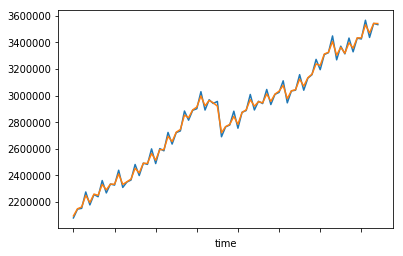

In [15]:
eu28_gdp_by_country.sum(axis=1).plot();
eu28_a10_total.sum(axis=1).plot();

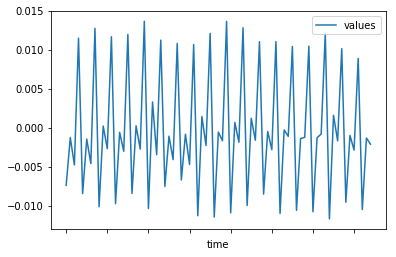

In [18]:
eu28_gdp.iloc[20:,].sub(eu28_a10_total.sum(axis=1), axis=0).div(eu28_gdp.iloc[20:,]).plot();

Разница между совокупного ВВП всех 28 стран, входящих в состав ЕС (синий ряд на рисунке), и суммой по всем отраслям по всем государствам (оранжевый ряд), не превышает  1.5%. Данные взяты из базы данных Евростат.

##### Квартальные сезонно сглаженные данные

Квартальные сезонно сглаженные данные - это ряды ВВП США для каждого из 50 штатов с разбивкой на 21 отрасль:  

- "INF" Информация и связь
- "AGR" Сельское хозяйство, лесное хозяйство, рыболовство и охота
- "RET" Розничная торговля
- "TRA" Транспорт и складирование
- "NDU" Производство товаров недлительного пользования
- "HLT" Здравоохранение и социальная помощь
- "CON" Строительство
- "DUR" Производство товаров длительного пользования
- "GOV" Правительство
- "ACC" Проживание и питание
- "UTI" Коммунальные услуги
- "MNG" Управление компаниями и предприятиями
- "ADM" Административные услуги
- "MIN" Горное дело
- "RER" Недвижимость
- "EDC" Образовательные услуги
- "ART" Искусство, развлечения и отдых
- "OTH" Прочие услуги, кроме государственных
- "FIN" Финансы и страхование
- "WHO" Оптовая торговля
- "PRO" Профессиональные, научные и технические услуги


Данные, использованные в этом анализе, взяты из базы данных FRED. 
В этих данных 11  рядов имели пропуски, по четырем из которых данные перестали собираться в 2008 году, поэтому в них пропуски были заполнены нулями. 
Остальные ряды были заполнены которые имели пропуски посередине были заполнены с помощью экспоненциально взвешенного скользящего среднего с шириной окна 4. 

Сносочка:

> Алгоритм, используемый в пакете R "imputeTS" имеет адаптивный размер окна: в случае длинных промежутков с пропущенными значениями, когда в заданном парметром $k$ окне доступно менее 2 значений не-NA, размер окна постепенно увеличивается до тех пор, пока не появятся как минимум 2 значения не-NA. Во всех остальных случаях алгоритм придерживается заданного размера окна. 

Квартальные оценки ВВП в США пересчитываются с учетом сезонных колебаний следующим образом: BEA оценивает соответствующие коэффициенты сезонной корректировки, после чего удаляет из временного ряда среднее влияние изменений, которые обычно происходят примерно в одно и то же время и примерно с одинаковой величиной каждый год. Сезонно несглаженные ряды по этому показтаелю BEA не публикует.

Показатели по ВВП публикуются в реальном денежном эквиваленте (за базовый год принмиается 2012).
    Нажо отметить, что, вообще говоря, значения реальных показателей ВДС по отраслям не  обязательно не обязательно дают в сумме сам показатель реального ВДС для каждого штата за интересующий период, поскольку относительные цены, используемые в качестве весов для корректировки показателей по отраслям, отличаются от общего уровня цен используемых для корректировки аггрегированного показателя. 
Для периодов, близких к 2012 году, когда обычно не было значительных отклонений относительных цен, от индекса цен по стране, показатель совпадает с суммированным, что видно на рисунке, но вообще не превышает 0.5%.

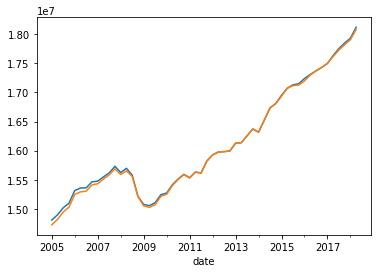

In [28]:
us_ind.sum(axis=1).plot()
us_gdp_geo.sum(axis=1).plot();

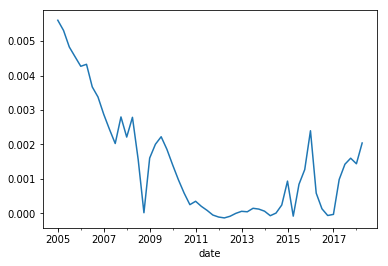

In [37]:
(us_ind.sum(axis=1).sub(us_gdp_geo.sum(axis=1), axis=0)).div(us_ind.sum(axis=1)).plot();

Разница между ВВП США и суммой ВДС по отраслям для каждого штата не превышает 2%. Для периодов, более отдаленных от отчетного года, остаток, как правило, становится больше из-за использования скорректированных на инфляцию показателей, по этой причине BEA также публикует показатели вклада основных компонентов, составляющих ряд ВВП, в его процентное изменение, что позволяет более точно определить показатели роста каждой конкретной отрасли.

Вклад в процентное изменение в реального показателя вычисляется по аналагичной представленноой выше формуле: 

$$ C\% Δ_{i,t} = 100 * \dfrac{(\frac{p_{i,t}}{P_t^F} + p_{i,t-1})(q_{i,t}-q_{i,t-1}) }{\sum_j(\frac{p_{j,t}}{P_t^F} + p_{j,t-1})(q_{j,t-1})} $$


где 
- $P_t^F$ - индекс цен Фишера для агрегата в период $t$ относительно периода $t − 1$;
- $p_{i,t}$ -  индекс цен компоненты (по отрасли/штату) $i$ в периоде $t$;
- $q_{i,t}$ -  номинальный показатель ВВП компоненты $i$ в периоде $t$.


##### Месячные данные 


Месячные данные  - данные по основным причинам смертности и рождаемости в каждом регионе, дающие в сумме естественный прирост населения РФ помесячно. 
Данные собраны за период с 2006-01 по 2019-01. 

Список основных причин смертности: 

- "УБ" - Умершие из-за болезней 
    - "ОД" - Болезни органов дыхания
    - "ОП" - Болезни органов пищеварения
    - "СК" - Болезни системы кровообращения 
    - "ИП" - Инфекционные и паразитарные болезни     
    - "НО" - Новообразования
- "УУ" - Убийство
    - "УБ" - Убийство
    - "СУ" - Самоубийство
- "УВ" - Умершие по внешим причинам
    - "ОА" - отравление алкоголем
    - "ТТ" - транспортные травмы всех видов
    - "ДП" - прочие причины


Данные взяты из базы данных ЕМИСС.

Если просуммировать по регионам все показатели из набора данных "Число зарегистрированных умерших (оперативные данные)" (синий ряд), значения как в целом, так и для каждого региона, различаются с просуммированными по рядам и видам смерти из набора "Число зарегистрированных умерших по основным классам и отдельным причинам смерти (оперативные данные)" (оранжевый ряд):

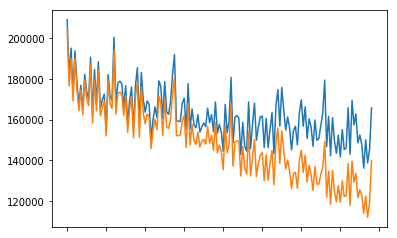

In [37]:
deaths.sum(axis=1).plot()
deaths_t.sum(axis = 1).plot();

Такое расхождение объясняется тем, что показатель «Число зарегистрированных умерших по основным классам и отдельным причинам смерти» является оперативной информацией, разрабатываемой по дате регистрации события в органах ЗАГС, без учета окончательных медицинских свидетельств о смерти, выданных взамен предварительных, поэтому разрабатываются не все причины смерти, а только основные классы и отдельные причины смерти, имеющие наибольший вес. Сумма указанных классов причин смерти не может давать значения по общему числу умерших, так как указаны не все классы причин смерти. 
Также в 2011 году методика разработки показателя была пересмотрена, чтобы соответствовать  Международной статистической классификации болезней и проблем, связанных со здоровьем, что можно наблюдать на графике (значительный рост разницы между рядами после 2011 года):

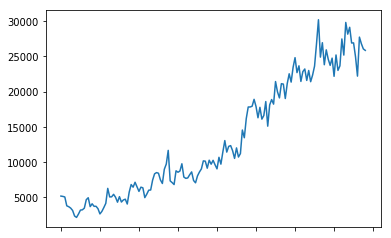

In [38]:
deaths.sum(axis=1).sub(deaths_t.sum(axis = 1),axis=0).plot();

В связи с этим разница между показателем смертности по каждому региону и суммой по всем причинам смертности была выделена, как прочие причины смерти.  



Сносочка: 
> С 2015 года также собираются данные по республике Крым и городу федерального значения Севастополю. Для возможности прогнозирования этих показателей данные по рождаемости и смертности по Крыму и Севастополю за 2006-2014 года были взяты из базы данных Держстат Украини


#### Методология

#### Сравнение качества прогнозов

- про кросс валидацию пару слов

- ~ 10% наблюдений: eu/us: прогноз на 4/8

Зависимость точности вычислений и метода для рядов разной длины?

Опишем метрики 

- https://otexts.com/fpp2/accuracy.html
- [Methods used in M3](https://www.sciencedirect.com/science/article/pii/S0169207006000239)


#### DM  тест

- We cannot compare forecasts for VECTORS of differing (in this case increasing) points in time, we must use a rolling window approach with a fixed h to compare these two models' h-point forecasts along time
- Also, note that Diebold himself suggests not using Diebold-Mariano test for comparing models rather than forecasts (Diebold "Comparing predictive accuracy, twenty years later: A personal perspective on the use and abuse of Diebold–Mariano tests", 2015).

Помимо использования стандартных при сравнении прогнозов моделей метрик:  RMSE, MAE, MAPE  мы проведем DM  тест ....


https://stats.stackexchange.com/questions/230566/diebold-mariano-test-in-case-of-nested-models-clark-mccracken-2001

https://files.stlouisfed.org/files/htdocs/wp/2009/2009-050.pdf

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.194.8459&rep=rep1&type=pdf


###### [Comparing Predictive Accuracy of two Forecasts: The Diebold-Mariano Test](http://www.phdeconomics.sssup.it/documents/Lesson19.pdf)

In empirical applications it is often the case that two or more
time series models are available for forecasting a particular
variable of interest.

Question: Are the forecasts equally good?

The loss associated with forecast $i$ is assumed to be a function
of the forecast error, $e_{it}$, and is denoted by $g(e_{it})$.

A problem with these loss function is that they are symmetric
functions (squared-error loss, absolute error loss)

When it is more costly to underpredict $y_t$ than to overpredict
it, the following loss function can be used:
$$g(e_{it}) = \exp (λe_{it}) − 1 − λe_{it}$$

We define the loss differential between the two forecasts by
$$d_t = g(e_{1t}) − g(e_{2t})$$
and say that the two forecasts have equal accuracy if and only
if the loss differential has zero expectation for all $t$.'

So, we would like to test the null hypothesis
$$H_0 : E(d_t) = 0,  ∀t$$
versus the alternative hypothesis
$$H_1 : E(d_t) \neq 0$$
The null hypothesis is that the two forecasts have the same
accuracy. The alternative hypothesis is that the two forecasts
have different levels of accuracy


Suppose that the forecasts are h(> 1)-step-ahead. In order to
test the null hypotesis that the two forecasts have the same
accuracy, Diebold-Mariano utilize the following statistic

$$DM = \frac{\bar{d}}{\sqrt{\frac{2\pi\hat{f}_d(0)}{T}}} \sim N(0;1)$$

where

$f_d (0) = \frac{1}{2π} \sum^{\infty}_{k=-\infty} γ_d (k)$ is the spectral density of the loss differential at frequency 0, 
$γ_d(k)$ is the autocovariance of the loss differential at lag $k$

$\hat{f}_d (0) =  \frac{1}{2π} \sum^{T−1}_{k=−(T−1)} I(\frac{k}{h − 1}) \hat{γ}_d (k)$
is a consistent estimate of $f_d (0)$

$\hat{γ}_d (k) = 1/T \sum^T_{t=|k|+1} (d_t − \bar{d})(d_{t−|k|} − \bar{d})$

$I(\frac{k}{h − 1}) =  \begin{cases} 1, \  \ if\  |\frac{k}{h − 1}| \leq 1 \\ 0, \  otherwise \end{cases}$


As the simulation experiments in Diebold and Mariano (1995)
show, the normal distribution can be a very poor
approximation of the DM test’s finite-sample null distribution.
Their results show that the DM test can have the wrong size,
rejecting the null too often, depending on the degree of serial
correlation among the forecast errors and the sample size, $T$.


Harvey, Leybourne, and Newbold (1997) (HLN) suggest that
improved small-sample properties can be obtained by:
1. making a bias correction to the DM test statistic, and
2. comparing the corrected statistic with a Student-t distribution with (T-1) degrees of freedom, rather than the standard normal.


$$HLN = DM\sqrt{(n+1-2h+h(h-1))/n} \sim T(n-1)$$


__A problem:__

The Diebold-Mariano test should not be applied
to situations where the competing forecasts are obtained using
two nested models

The root of the problem is that, at the population level, if the
null hypothesis of equal predictive accuracy is true, the forecast
errors from the competing models are exactly the same and
perfectly correlated, which means that the numerator and
denominator of a Diebold-Mariano test are each limiting to
zero as the estimation sample and prediction sample grow.

However, when the size of the estimation sample remains finite
as the size of the prediction sample grows, parameter
estimates are prevented from reaching their probability limits
and the Diebold-Mariano test remains asymptotically valid
even for nested models, under some regularity assumptions
(see Giacomini and White 2003).

> ##### [Nested model](http://quantile.ru/12/12-AT.pdf) 

> Когда модель A является частным случаем модели B, т. е. A можно получить из B, наложив
на параметры некоторые ограничения (и, возможно, сделав замену переменных), то говорят,
что модель A вложена (nested) в модель B. Если же A и B не сводятся друг к другу с помощью наложения ограничений на параметры, то говорят, что A и B являются невложенными
(non-nested); примером могут служить модели логит и пробит. Если правильность спецификации одной модели проверяют на основе сопоставления с невложенной альтернативной
моделью, то говорят о невложенных гипотезах. 


> В том же контексте выбора модели есть похожий термин encompassing (охват). Принцип
охвата заключается в том, что если модель правильно специфицирована, то она должна
быть способна объяснять результаты использования альтернативной модели. О выборе мо-
дели, невложенных и охватывающих моделях см. Gourieroux & Monfort (1994), Pesaran &
Weeks (2001), Greene (2012).

If you wonder whether one forecast (say, 𝑓1) is statistically more accurate than another (say, 𝑓2), the Diebold-Mariano (DM) test will tell you that. At this point there is no talk of the models that generated the forecasts.
The DM test (as any other statistical test) targets making inference on the population rather than the current sample. If (1) the DM test tells you with 95% confidence that 𝑓1 beats 𝑓2 and (2) the forecast generating processes and the data generating process all remain unchanged in the future, then you would expect that 𝑓1 will beat 𝑓2 also in the future.
How can you benefit from this result? If you have the forecast generating process available, you could choose to use the one for 𝑓1 rather than for 𝑓2. However, Diebold (2015) does not encourage that:

The Diebold-Mariano (DM) test was intended for comparing forecasts; it has been, and remains, useful in that regard. The DM test was not intended for comparing models. Much of the large ensuing literature, however, uses DM-type tests for comparing models, in pseudo-out-of-sample environments. In that case, simpler yet more compelling full-sample model comparison procedures exist; they have been, and should continue to be, widely used.

Additional information:


- [Statistical Tests for Multiple Forecast Comparison](http://statweb.stanford.edu/~ckirby/ted/conference/Roberto%20Mariano.pdf): other  tests like:
    - Morgan-Granger-Newbold (MGN) Test (1977), 
    - Meese-Rogoff (MR) Test (1988), 
    - Diebold-Mariano (DM) Test (1995), 
    - HLN (1997): Small-Sample Modification of DM Test 
    - A Multivariate Test 

#### CV

- [How To Backtest Machine Learning Models for Time Series Forecasting](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)
- [Evaluating forecast accuracy](https://otexts.com/fpp2/accuracy.html)
- Чтобы были сопоставимы, делаем кроссвалидацию с увеличивающимся окном 

